### Задание проекта.

Маркетинговому аналитику  поступило задание обнаружить проблему. Задача — разобраться в причинах  убытков . Есть данные о пользователях: лог сервера с данными об их посещениях, выгрузка их покупок за этот период, рекламные расходы. Предстоит изучить: откуда приходят пользователи и какими устройствами они пользуются, сколько стоит привлечение пользователей из различных рекламных каналов; сколько денег приносит каждый клиент, когда расходы на привлечение клиента окупаются, какие факторы мешают привлечению клиентов. 


по условиям :
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14


# Шаг 1. Загрузим данные и подготовим их к анализу


In [1]:
# загрузим необходимые библиотеки
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np


In [2]:

# сохраним данные в переменных
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv ('/datasets/orders_info_short.csv')
costs = pd.read_csv ('/datasets/costs_info_short.csv')
# выведем на экран первые пять строк 
display(visits.head())
display(orders.head())
display(costs.head())

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [3]:
# выведем общую информацию
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   

In [4]:
# приведём названия колонок к змеиному регистру

visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()
# переименуем колонки в соответствии с хорошим стилем
visits = visits.rename(columns={'user id':'user_id','session start':'session_start',
                                'session end':'session_end'})
orders = orders.rename(columns={'user id':'user_id', 'event dt':'event_dt'})

# проверим названия
display(visits.head())
display(orders.head())
display(costs.head())

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [6]:
# проверим данные на наличие дубликатов
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


In [7]:
# преобразуем данные о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])

orders['event_dt'] = pd.to_datetime(orders['event_dt']).astype('datetime64[D]')

costs['dt'] = pd.to_datetime(costs['dt']).astype('datetime64[D]')


* Данные загружены,изучена общия информация о данных, названия колонок приведены к хорошему стилю, проведена проверка на наличие дубликатов и преобразованы данные о времени в формат datetime64.  

# Шаг 2. Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии.


### LTV, ROI

In [8]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Retention

In [9]:
def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Conversion

In [10]:
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_orders = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_orders[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


Необходимые для анализа функции заданы.

### plot_ltv_roi

In [11]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()





### filter data

In [12]:

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df



### plot_retention

In [13]:
def plot_retention(retention, retention_history, horizon, window=14,dimensions=['channel']):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
   

### plot_conversion

In [14]:
def plot_conversion(conversion, conversion_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()



# Шаг 3. Проведем исследовательский анализ данных

Построим профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

### **Создадим профили пользователей.**

In [15]:
 # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещени
profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )
display(profiles.head())

,user_id,first_ts,channel,device,region
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States
2,6085896,2019-10-01 09:58:33,organic,iPhone,France
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States


In [16]:
 # для когортного анализа определяем дату первого посещения
 # и первый день месяца, в который это посещение произошло
profiles['dt'] = profiles['first_ts'].astype('datetime64[D]')
profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
# выведем на экран таблицу
display(profiles.head())
    

,user_id,first_ts,channel,device,region,dt,month
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01


In [17]:
 # добавляем признак платящих пользователей
profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
# выведем на экран таблицу
display(profiles.head())


,user_id,first_ts,channel,device,region,dt,month,payer
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False


In [18]:
 # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
new_users = (
          profiles.groupby(['dt', 'channel'])
          .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
          .rename(columns={'user_id': 'unique_users'})
          .reset_index()  # возвращаем dt и channel из индексов
      )
new_users['dt'] = pd.to_datetime(new_users['dt']).astype('datetime64[D]')

# выведем на экран таблицу
display(new_users.head())

,dt,channel,unique_users
0,2019-05-01,AdNonSense,39
1,2019-05-01,FaceBoom,104
2,2019-05-01,LeapBob,12
3,2019-05-01,MediaTornado,26
4,2019-05-01,OppleCreativeMedia,18


In [19]:
 # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
costs['dt'] = pd.to_datetime(costs['dt']).astype('datetime64[D]')
costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    
 # выведем на экран таблицу   
display(costs.head())

,dt,channel,costs,unique_users
0,2019-05-01,FaceBoom,113.3,104
1,2019-05-02,FaceBoom,78.1,72
2,2019-05-03,FaceBoom,85.8,76
3,2019-05-04,FaceBoom,136.4,123
4,2019-05-05,FaceBoom,122.1,113


In [20]:
 # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
costs['acquisition_cost'] = costs['costs'] / costs['unique_users']
# выведем на экран таблицу
display(costs.head().round(2))

,dt,channel,costs,unique_users,acquisition_cost
0,2019-05-01,FaceBoom,113.3,104,1.09
1,2019-05-02,FaceBoom,78.1,72,1.08
2,2019-05-03,FaceBoom,85.8,76,1.13
3,2019-05-04,FaceBoom,136.4,123,1.11
4,2019-05-05,FaceBoom,122.1,113,1.08


In [21]:
 # добавим стоимость привлечения в профили
#profiles['dt'] = profiles['first_ts']
profiles = profiles.merge(
          costs[['dt', 'channel', 'acquisition_cost']],
          on=['dt', 'channel'],
          how='left',
)
# выведем на экран таблицу
display(profiles.head().round(2))

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,NaN
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23


In [22]:
# органические пользователи не связаны с данными о рекламе,
# поэтому в столбце acquisition_cost у них значения NaN
# заменим их на ноль, ведь стоимость привлечения равна нулю
profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
# выведем на экран таблицу
display(profiles.head().round(2))
# выведем на экран общую информацию
profiles.info()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23


<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  datetime64[ns]
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](3), float64(1), int64(1), object(3)
memory usage: 10.4+ MB


### Выясним, сколько денег приносит каждый клиент.



In [23]:
#  в профили добавим суммарную  выручку из таблицы  orders и сохраним в переменной profiles_revenue
user_id_revenue = orders.groupby(['user_id']).agg({'revenue': 'sum'}).rename(columns={'revenue': 'revenue_sum'}).reset_index()
profiles_revenue = profiles.merge(user_id_revenue, on=['user_id'],how='left')
# выведем на экран первые 5 строк
display(profiles_revenue.head())
# выведем на экран результат
print('Общая выручка составляет',profiles_revenue['revenue_sum'].sum())

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost,revenue_sum
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172,14.97
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237,NaN
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000,NaN
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235,NaN
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769,NaN


Общая выручка составляет 215962.88


### **Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.**



In [24]:
# сохраним в переменной region_users количество пользователей в регионах 
region_users = (
          profiles.groupby(['region'])
          .agg({'user_id': 'count'})
         # столбец с числом пользователей назовём unique_users
          .rename(columns={'user_id': 'region_users'})
          .reset_index()  # возвращаем dt и channel из индексов
)
# сохраним в переменной region_users_payer количество платстраныящих пользователей в регионах
region_users_payer = (
          profiles.query('payer==True').groupby(['region'])
          .agg({'user_id': 'count'})
         # столбец с числом пользователей назовём unique_users
          .rename(columns={'user_id': 'region_users_payer'})
          .reset_index()  # возвращаем dt и channel из индексов
)
# объединим переменные по полю 'region'
region_users_payer = region_users_payer.merge(region_users,on=['region'], how='left')
# в колонке 'pay_per' найдём долю платящих пользователей из каждой страны в процентах
region_users_payer['pay_per_region'] = region_users_payer['region_users_payer']/region_users_payer['region_users']*100
# выведем таблицу на экран
display(region_users_payer.sort_values(by='pay_per_region', ascending=False))

,region,region_users_payer,region_users,pay_per_region
3,United States,6902,100002,6.901862
1,Germany,616,14981,4.111875
2,UK,700,17575,3.982930
0,France,663,17450,3.799427


In [25]:
# узнаем сколько выручки получили с ползователей в зависимости от страны привлечения

display(profiles_revenue.groupby(['region']).agg({'revenue_sum': 'sum'}).sort_values(by='revenue_sum', ascending=False))

,revenue_sum
region,
United States,149922.22
UK,24742.32
France,21554.78
Germany,19743.56


* Процент покупателей United States выше в 1,7 раза чем процент в Germany. CАC резко начал расти в United States c конца мая  и превысил уровень САС других стран в 4 раза , в других странах рост  в конце мая был не значительный, затем прекратился. Выручка в United States более чем в 5 раз превышает выручку в других странах.

### **Выясним, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.**

In [26]:
#Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
#сохраним в переменной device_users количество пользователей в регионах 
device_users = (
          profiles.groupby(['device'])
          .agg({'user_id': 'count'})
         # столбец с числом пользователей назовём unique_users
          .rename(columns={'user_id': 'device_users'})
          .reset_index()  # возвращаем dt и channel из индексов
)
# сохраним в переменной device_users_payer количество платящих для каждого устройства
device_users_payer = (
          profiles.query('payer==True').groupby(['device'])
          .agg({'user_id': 'count'})
         # столбец с числом пользователей назовём unique_users
          .rename(columns={'user_id': 'device_users_payer'})
          .reset_index()  # возвращаем dt и channel из индексов
)
# объединим переменные по полю 'device'
device_users_payer = device_users_payer.merge(device_users,on=['device'], how='left')
# в колонке 'pay_per' найдём долю платящих пользователей для каждого устройства в процентах
device_users_payer['pay_per_device'] = device_users_payer['device_users_payer']/device_users_payer['device_users']*100
# выведем таблицу на экран
display(device_users_payer.sort_values(by='pay_per_device', ascending=False))

,device,device_users_payer,device_users,pay_per_device
1,Mac,1912,30042,6.364423
3,iPhone,3382,54479,6.207897
0,Android,2050,35032,5.851793
2,PC,1537,30455,5.046790


In [27]:
# узнаем сколко выручки получили с ползователей для каждого устройства

device_revenue_sum =  profiles_revenue.groupby(['device']).agg({'revenue_sum': 'sum'})
# расчитаем среднюю выручку в колонке 'rev_med'
device_revenue_sum = device_revenue_sum.merge(device_users_payer,on=['device'], how='left' )
device_revenue_sum ['rev_med']= device_revenue_sum ['revenue_sum']/device_revenue_sum ['device_users_payer']
# выведем на экран нужные колонки
display(device_revenue_sum[['device','revenue_sum','rev_med']].sort_values(by='rev_med', ascending=False))

,device,revenue_sum,rev_med
2,PC,43398.46,28.235823
0,Android,51414.63,25.080307
3,iPhone,78275.79,23.144823
1,Mac,42874.00,22.423640


* Процент платящих пользователей в зависимости от устройства находится примерно на одном уровне- с небольшим преимуществом лидирует пара Mac и iPhone, а суммарная выручка выше у пользователей iPhone а средняя выручка выше у пользователей  PC. САС резко вырос в конце мая и продолжает расти на всех устройствах.

### Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [28]:
#Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.
#сохраним в переменной channel_users количество пользователей канала привлечения 
channel_users = (
          profiles.groupby(['channel'])
          .agg({'user_id': 'count'})
         # столбец с числом пользователей назовём unique_users
          .rename(columns={'user_id': 'channel_users'})
          .reset_index()  # возвращаем dt и channel из индексов
)
# сохраним в переменной channel_users_payer количество платящих пользователей канала привлечения
channel_users_payer = (
          profiles.query('payer==True').groupby(['channel'])
          .agg({'user_id': 'count'})
         # столбец с числом пользователей назовём 'channel_users_payer'
          .rename(columns={'user_id': 'channel_users_payer'})
          .reset_index()  # возвращаем dt и channel из индексов
)
# объединим переменные по полю 'channel'
channel_users_payer = channel_users_payer.merge(channel_users,on=['channel'], how='left')
# в колонке 'pay_per' найдём долю платящих пользователей канала привлечения в процентах
channel_users_payer['pay_per'] = channel_users_payer['channel_users_payer']/channel_users_payer['channel_users']*100
# выведем таблицу на экран
channel_users_payer = channel_users_payer.sort_values(by='pay_per', ascending=False)
display(channel_users_payer)

,channel,channel_users_payer,channel_users,pay_per
1,FaceBoom,3557,29144,12.204914
0,AdNonSense,440,3880,11.340206
9,lambdaMediaAds,225,2149,10.469986
6,TipTop,1878,19561,9.600736
5,RocketSuperAds,352,4448,7.913669
7,WahooNetBanner,453,8553,5.296387
8,YRabbit,165,4312,3.826531
3,MediaTornado,156,4364,3.574702
2,LeapBob,262,8553,3.063253
4,OppleCreativeMedia,233,8605,2.707728


In [29]:
# узнаем сколко выручки получили с ползователей в зависимости от канала привлечения

display(profiles_revenue.groupby(['channel']).agg({'revenue_sum': 'sum'}).sort_values(by='revenue_sum', ascending=False))

,revenue_sum
channel,
TipTop,69574.76
organic,46627.23
FaceBoom,25637.66
WahooNetBanner,20006.63
RocketSuperAds,11598.32
LeapBob,9560.13
lambdaMediaAds,8941.70
OppleCreativeMedia,8365.53
YRabbit,6201.43


* Изучив данные  покупающих пользователей по каналам привлечения, установлены лидеры :FaceBoom , AdNonSense и lambdaMediaAds. Но в топе по суммарной выручке FaceBoom лишь третий, а первым оказался TipTop. Почётное второе место по праву занял organic. САС на канале TipTop имеет резкий рост с середины мая и продолжает расти, тогда как САС на других каналах остается на постоянном уровне весь период наблюдений. Выручка на канале TipTop больше в 1,5 раз  следующего по рейтингу конкурента organic, а САС больше САС organic в 3,5 раза.

In [30]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  datetime64[ns]
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](3), float64(1), int64(1), object(3)
memory usage: 10.4+ MB


In [31]:
# выведем минимальную и максимальную даты привлечения пользователей
print('минимальная  дата привлечения пользователей',profiles['dt'].min())

print('максимальная дата привлечения пользователей',profiles['dt'].max())


минимальная  дата привлечения пользователей 2019-05-01 00:00:00
максимальная дата привлечения пользователей 2019-10-27 00:00:00


Определим минимальную и максимальную даты привлечения пользователей по журналу покупок. Минимальная дата 2019-05-01, максимальная 2019-10-31 .

In [32]:
# сгруппируем  журнал покупок по'event_dt' и user_id и определим даты первой и последней покупки
orders.groupby(['event_dt','user_id'])['revenue'].agg(['sum', 'count'])

sum  count
event_dt   user_id                  
2019-05-01 29144643737   4.99      1
           59058997486   4.99      1
           64474110919   4.99      1
           68752468250   4.99      1
           129100331057  4.99      1
...                       ...    ...
2019-10-31 982840561820  4.99      1
           985295994252  4.99      1
           997759720680  4.99      1
           998522205936  4.99      1
           999076984039  9.99      1

[40210 rows x 2 columns]

# Шаг 4. Маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

### Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. 
Визуализируем изменения метрик во времени.

In [33]:
# Посчитаем общую сумму расходов на маркетинг
print('Общая сумма расходов на маркетинг:',costs['costs'].sum().round(0))

Общая сумма расходов на маркетинг: 105497.0


In [34]:
# Общая сумма расходов на маркетинг по каналам
costs.groupby(['channel']).agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


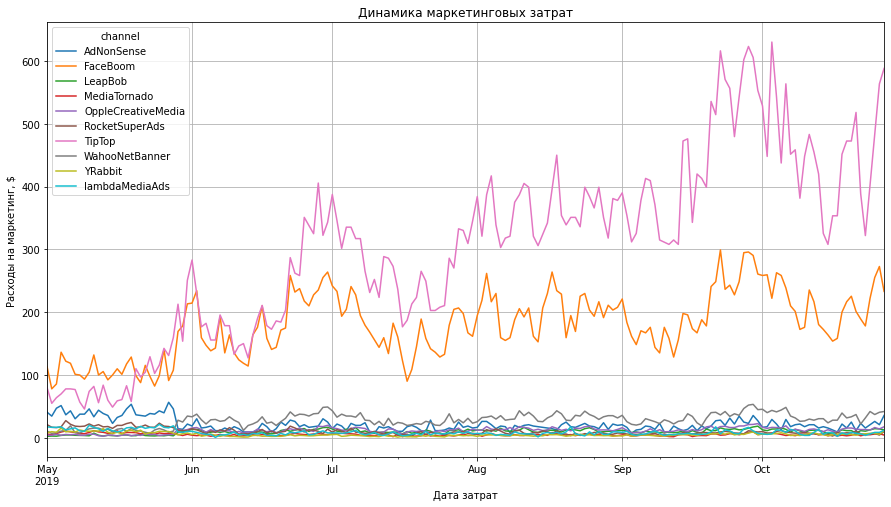

In [35]:
# построим график изменения маркетинговых затрат в зависимости от канала привлечения
costs.pivot_table(
    index='dt', columns='channel', values='costs', aggfunc='mean'
).plot(grid=True, figsize=(15, 8))
plt.ylabel('Расходы на маркетинг, $')
plt.xlabel('Дата затрат')
plt.title('Динамика маркетинговых затрат')
plt.show()

* Наибольшие маркетинговые расходы были понесенеы на рекламу  в  TipTop и FaceBoom- рост начинается в конце мая и продолжает расти на канале TipTop более быстрыми темпами , рекламные траты в остальных каналах находятся приблизительно на одном уровне .

### Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника.
Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика.


In [36]:

user_costs = profiles['acquisition_cost'].sum()/len(profiles[ ~ profiles['channel']. isin (['organic'])])

print('средний CAC на одного пользователя для всего проекта',user_costs.round(2))

средний CAC на одного пользователя для всего проекта 1.13


In [37]:
# расчитаем средний САС на одного пользователя по каналам привлечения
user_costs_channel = profiles.groupby(['channel']).agg({'acquisition_cost': 'sum','user_id':'count'}).rename(columns={'user_id': 'channel_users','acquisition_cost':'sum_costs'})
user_costs_channel['cac_channel'] =  user_costs_channel['sum_costs']/user_costs_channel['channel_users']                                                                                
# выведем на экран таблицу
print(user_costs_channel.sort_values(by='cac_channel', ascending=False).round(2))

                    sum_costs  channel_users  cac_channel
channel                                                  
TipTop               54751.30          19561         2.80
FaceBoom             32445.60          29144         1.11
AdNonSense            3911.25           3880         1.01
lambdaMediaAds        1557.60           2149         0.72
WahooNetBanner        5151.00           8553         0.60
RocketSuperAds        1833.00           4448         0.41
OppleCreativeMedia    2151.25           8605         0.25
YRabbit                944.22           4312         0.22
MediaTornado           954.48           4364         0.22
LeapBob               1797.60           8553         0.21
organic                  0.00          56439         0.00


* наибольший САС на канале TipTop в 2,5 раза превышает второй по рейтингу САС на канале FaceBoom.

# Шаг 5. Оценим окупаемость рекламы для привлечения пользователей



### 5.1. Проанализируем общую окупаемость рекламы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

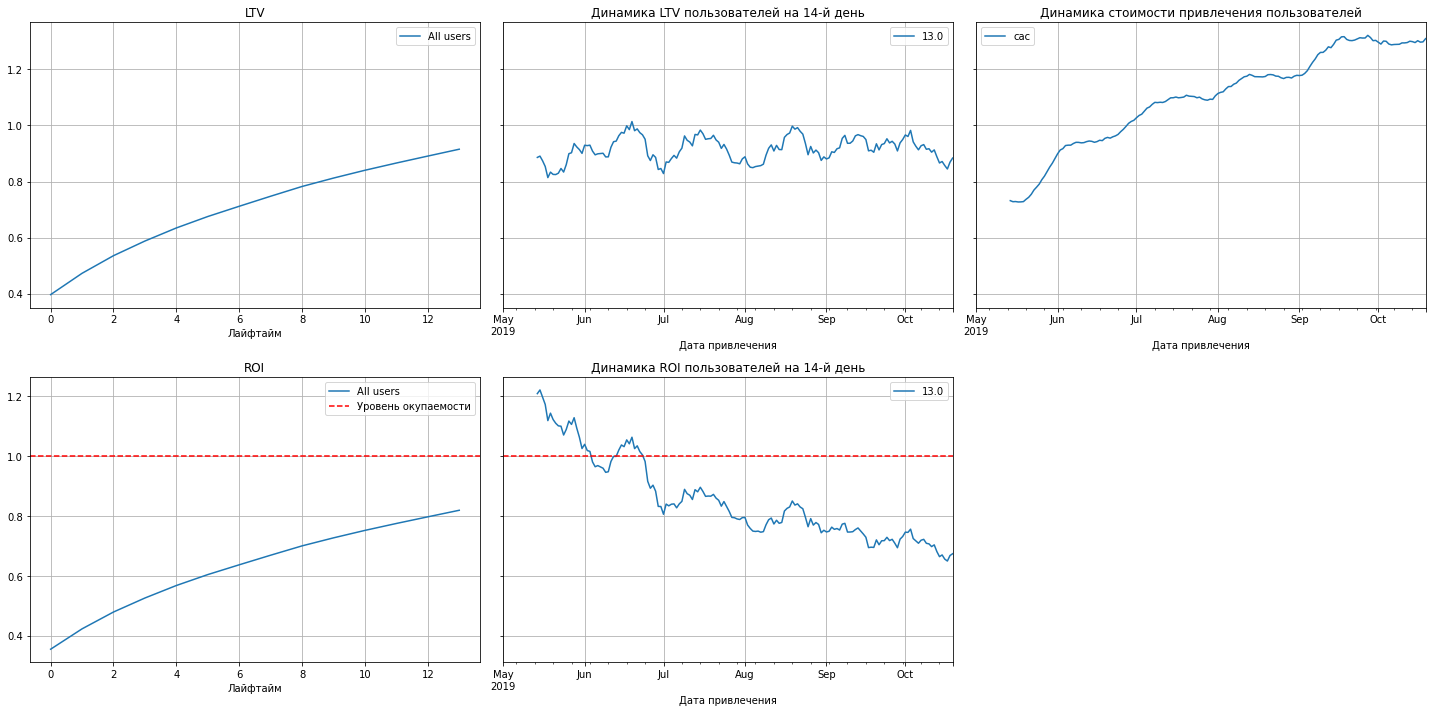

In [38]:


# считаем LTV, CAC и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('channel != "organic"') ,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    
)

# строим графики

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

* Промежуточный вывод:

Даже к концу анализируемого периода не удалось компенсировать рекламные расходы, и дохода от вложенных средств в маркетинг компания пока не получила. Маркетинговые расходы , резко возрастающие  с конца мая ещё не окупились.Показатль ROI снижается- очень плохо! Стоимость привлечения пользователей продолжает расти.

### 5.2. Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

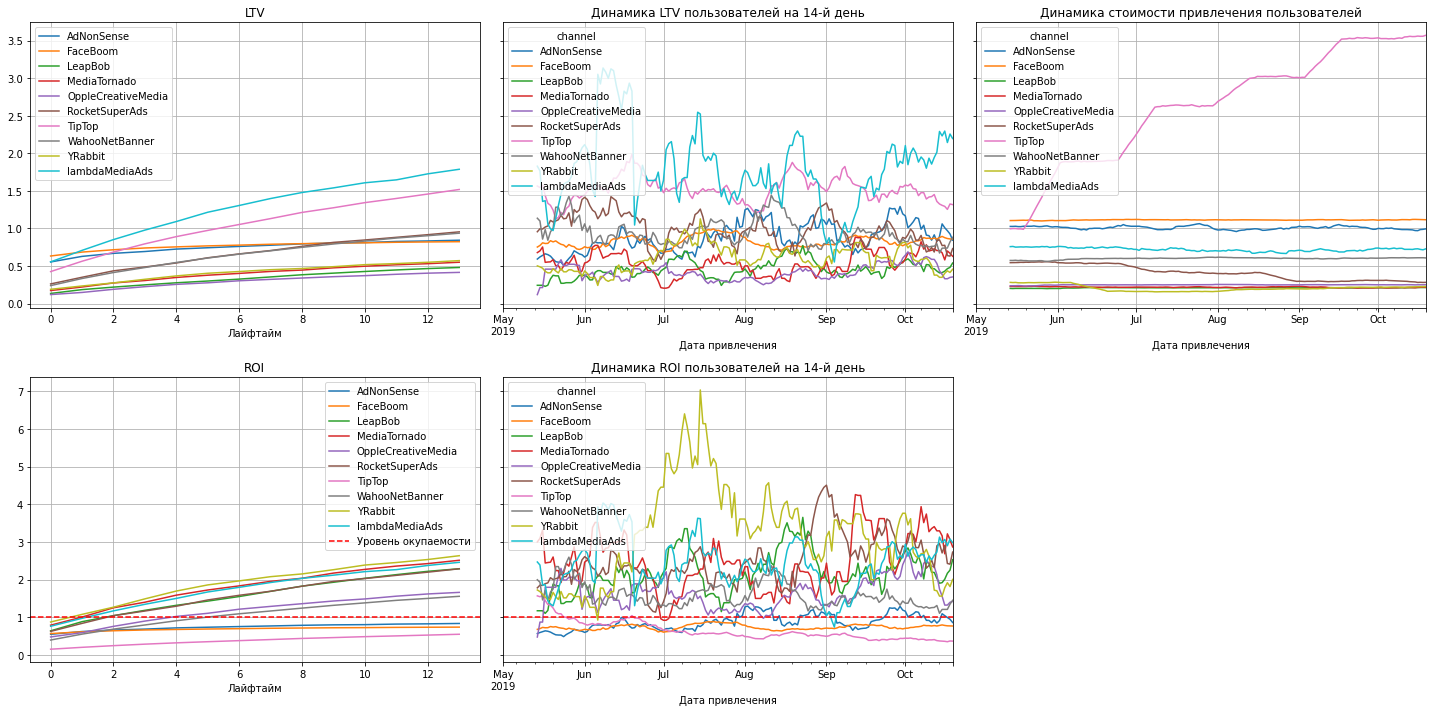

In [39]:
# считаем LTV, CAC и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('channel != "organic"'),
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['channel'],
)
# строим графики

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

* Промежуточный вывод:

Аутсайдерами по окупаемости являются  каналы TipTop ,FaceBoom и AdNonSens, самая высокая окупаемость у канала YRabbit. Основная масса каналов рекламные расходы возместила с лихвой. Не удалось этого только каналам TipTop,FaceBoom и AdNonSens . 

### 5.3. Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

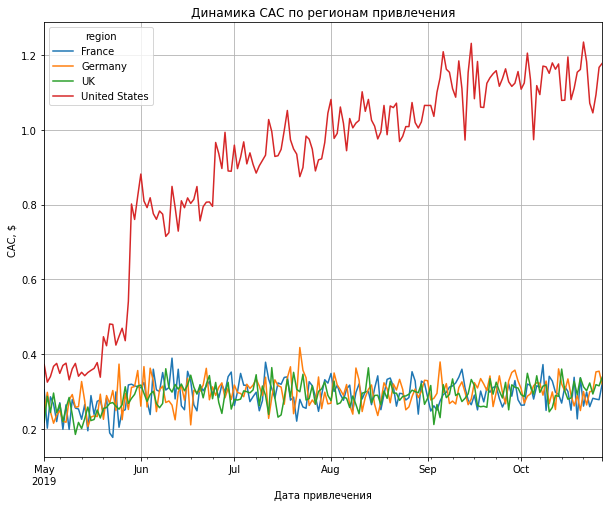

In [40]:
# построим график изменения САС по регионам привлечения
profiles.pivot_table(
    index='dt', columns='region', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 8))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по регионам привлечения')
plt.show()

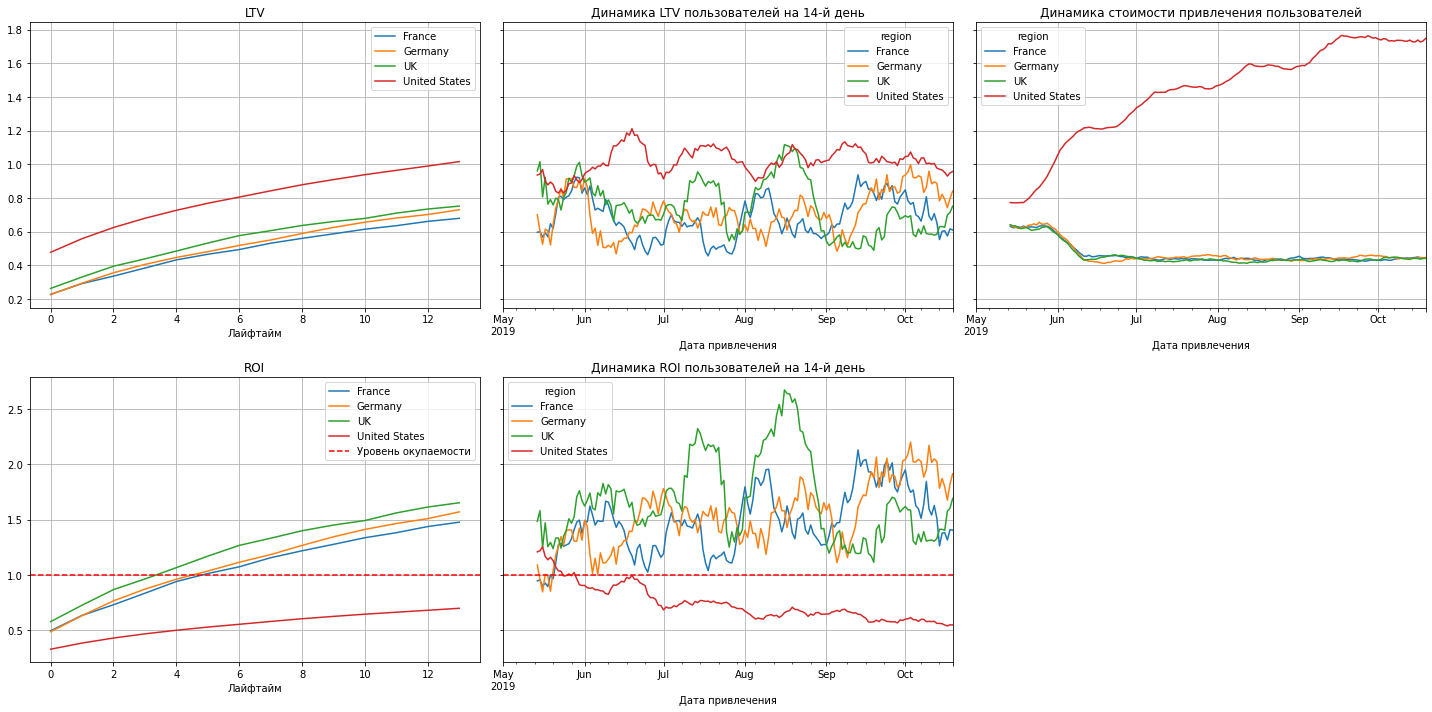

In [41]:
# считаем LTV, CAC и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('channel != "organic"'),
    orders,
    datetime(2019, 11, 1).date(),
    14,  dimensions=['region'],
)

# строим графики

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

* Промежуточный вывод:

Наибольшие рекламные расходы были осуществлены в США, но они не окупились. Рекламные расходы в других странах окупились и принесли прибыль, которая покрыла убыток США. Динамика САС показывает, что когда в США стоимость привлечения начала резко расти, в других странах этот показатель резко снизился, все средства пошли в США ПОЧЕМУ? Окупаемость маркетинговых вложений в США продолжает снижаться на фоне положительной динамики окупаемости в других странах.

### 5.3.1 Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

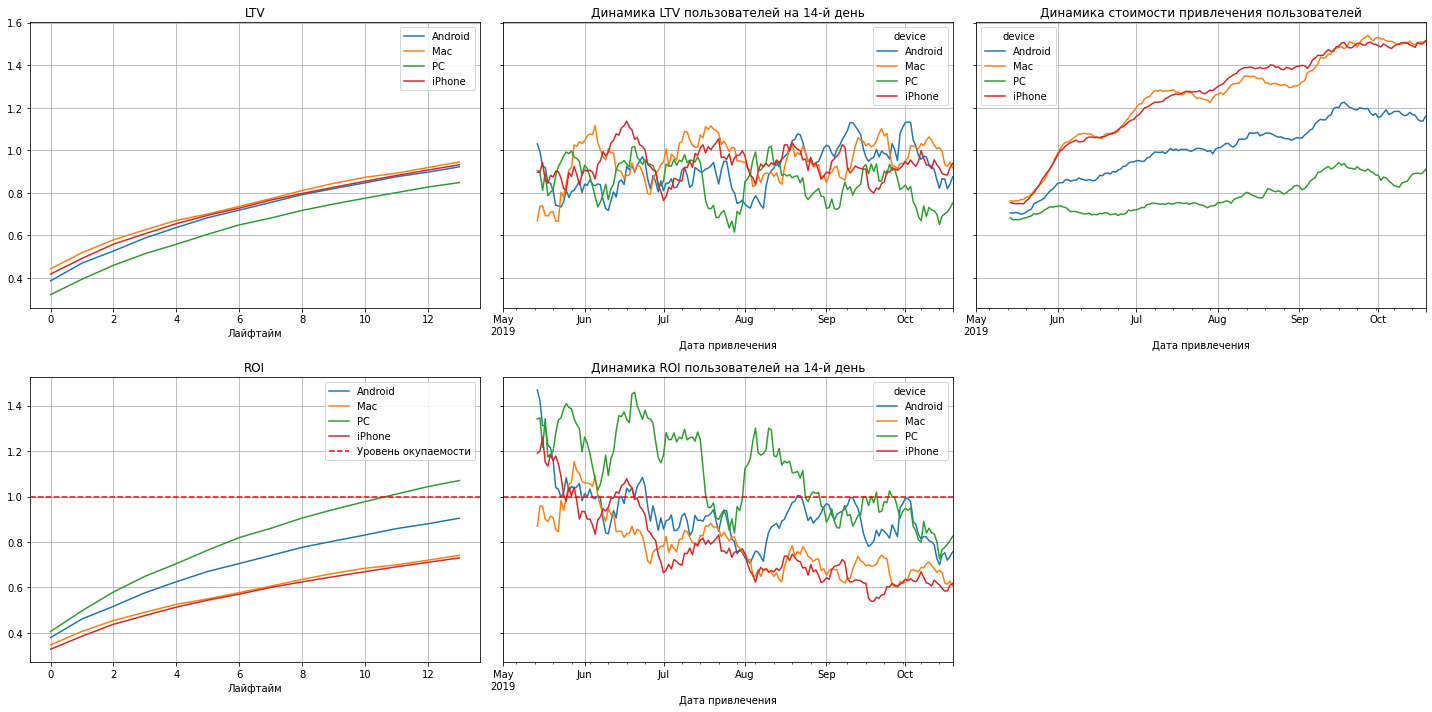

In [42]:
# считаем LTV, CAC и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('channel != "organic"'),
    orders,
    datetime(2019, 11, 1).date(),
    14,  dimensions=['device'],
)

# строим графики

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

* Промежуточный вывод:

Наибольшие рекламные расходы были осуществлены среди владельцев Mac и iPhone, но они не окупились, как не окупились и расходы нацеленные на владельцев Android. Рекламные расходы  окупились лишь у рекламы среди владельцев РС и то лишь к концу анализируемого периода.

### 5.4. Построим и изучим графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

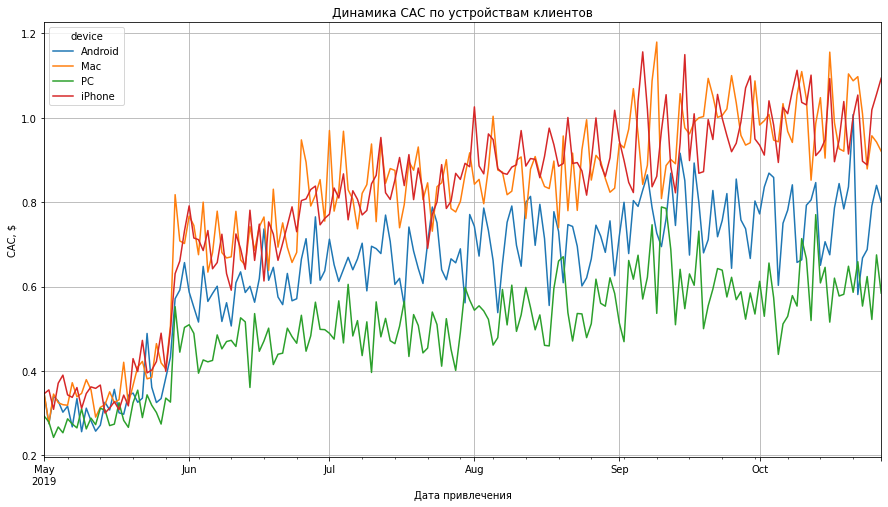

In [43]:
# выведем график САС по устройствам клиентов
profiles.pivot_table(
    index='dt', columns='device', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 8))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по устройствам клиентов')
plt.show()

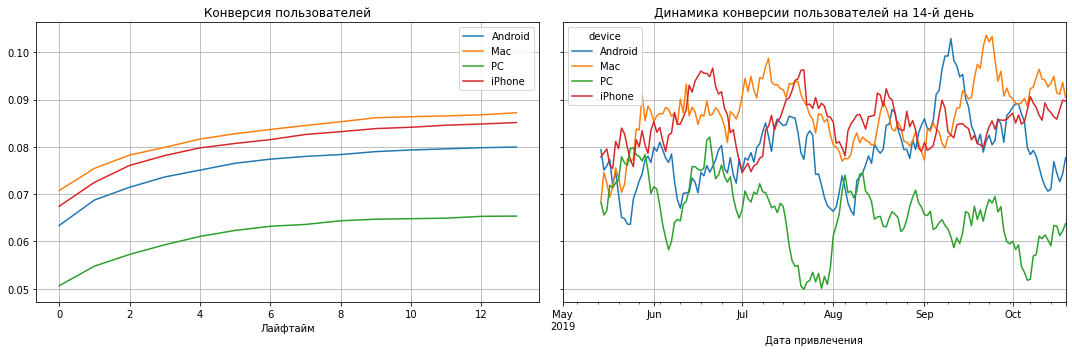

In [44]:
#  вызовем функцию и построим график
conversion_raw, conversion, conversion_history = get_conversion(
    profiles.query('channel != "organic"'),
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['device'],
    
)


plot_conversion(conversion, conversion_history, 14) 

In [45]:
#  вызовем функцию 
retention_raw, retention, retention_history = get_retention(
    profiles.query('channel != "organic"'), visits, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

<Figure size 432x288 with 0 Axes>

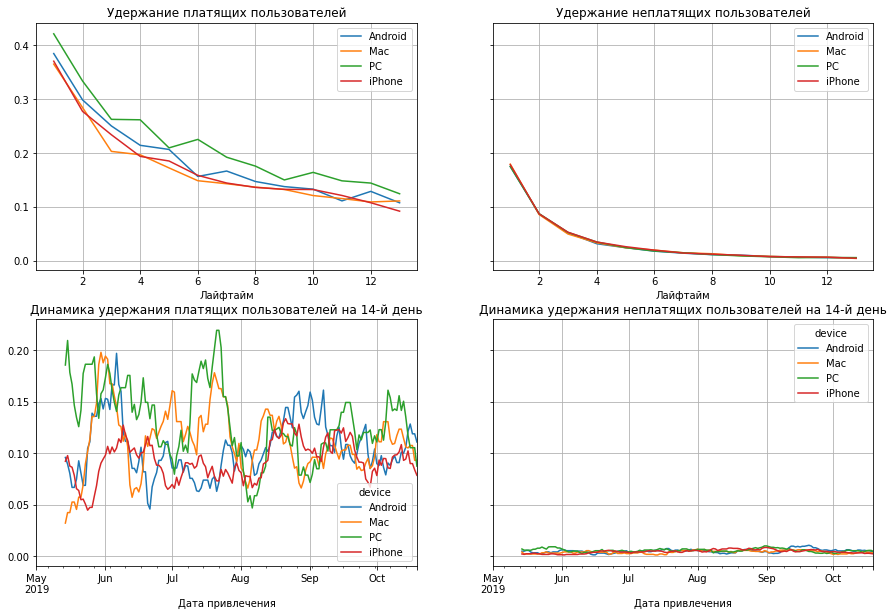

In [46]:
 #   вызовем функцию и построим график  
plt.tight_layout()
plt.show()

plot_retention(retention, retention_history,14,dimensions=['channel']) 

* Промежуточный вывод:

 Конверсия выше у владельцем Mac , а удержание лучше у пользователей РС, Динамика показателей неплатящих пользователей практически одинакова у всех устройств.

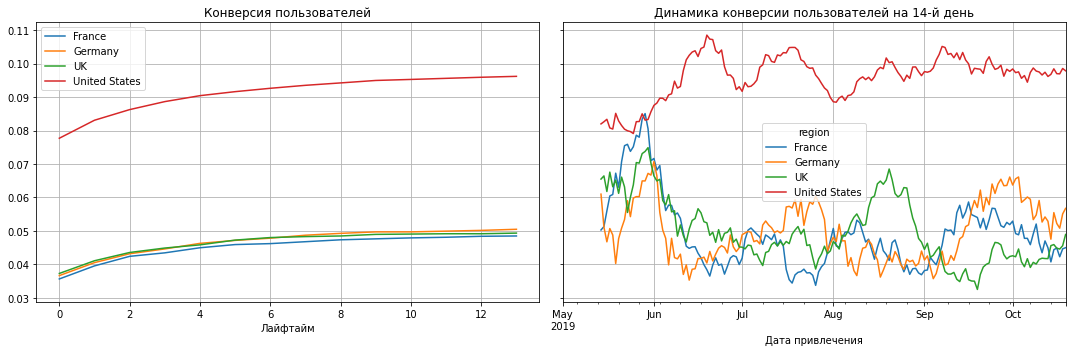

In [47]:
#  вызовем функцию и построим график

conversion_raw, conversion, conversion_history = get_conversion(
    profiles.query('channel != "organic"'),
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['region'],
    
)


plot_conversion(conversion, conversion_history, 14) 

In [48]:
#  вызовем функцию 
retention_raw, retention, retention_history = get_retention(
    profiles.query('channel != "organic"'), visits, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)

<Figure size 432x288 with 0 Axes>

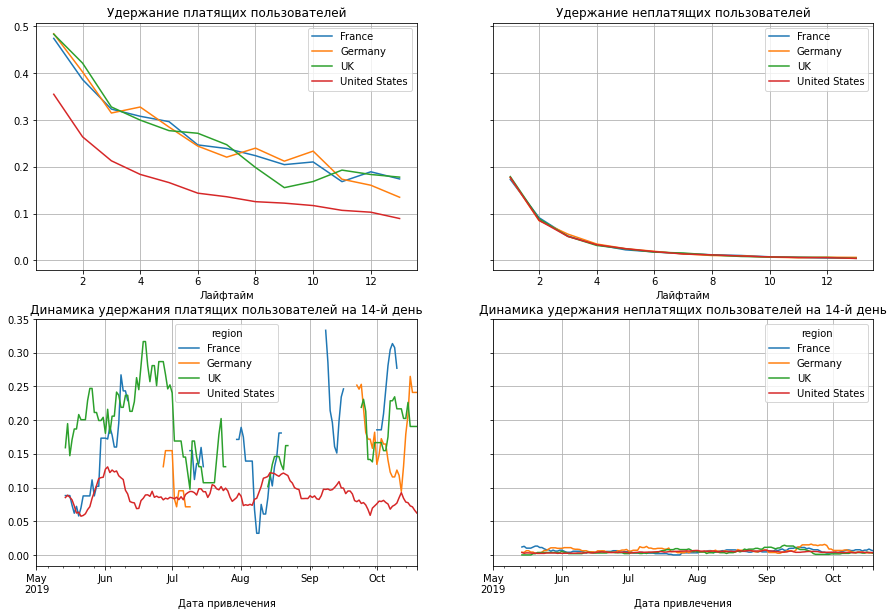

In [49]:
#  вызовем функцию и построим график
plt.tight_layout()
plt.show()

plot_retention(retention, retention_history,14,dimensions=['channel']) 

* Промежуточный вывод:

 Конверсия в разы выше у покупателей США ,но там же и самое низкое удержание пользователей.Показатель удержания остальных стран приблизительно на одном уровне, чуть выше в Англии, Динамика показателей неплатящих пользователей практически одинакова у всех стран.

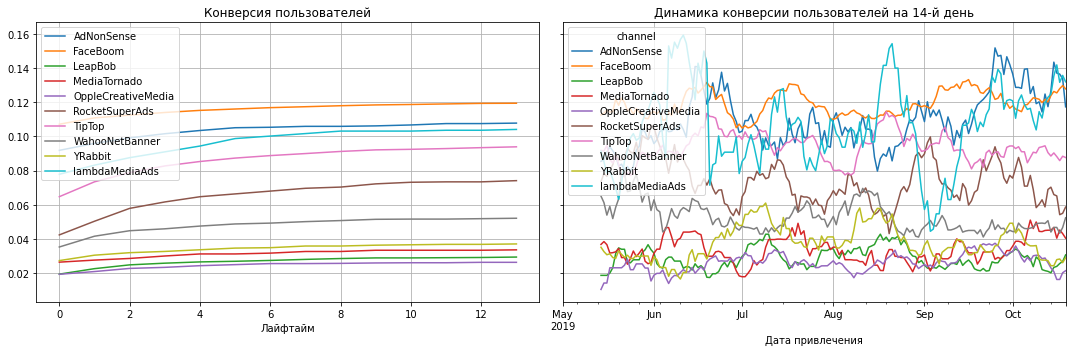

In [50]:
#  вызовем функцию и построим график
conversion_raw, conversion, conversion_history = get_conversion(
    profiles.query('channel != "organic"'),
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['channel'],
)
plot_conversion(conversion, conversion_history, 14) 

In [51]:
#  вызовем функцию 
retention_raw, retention, retention_history = get_retention(
    profiles.query('channel != "organic"'), visits, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)

<Figure size 432x288 with 0 Axes>

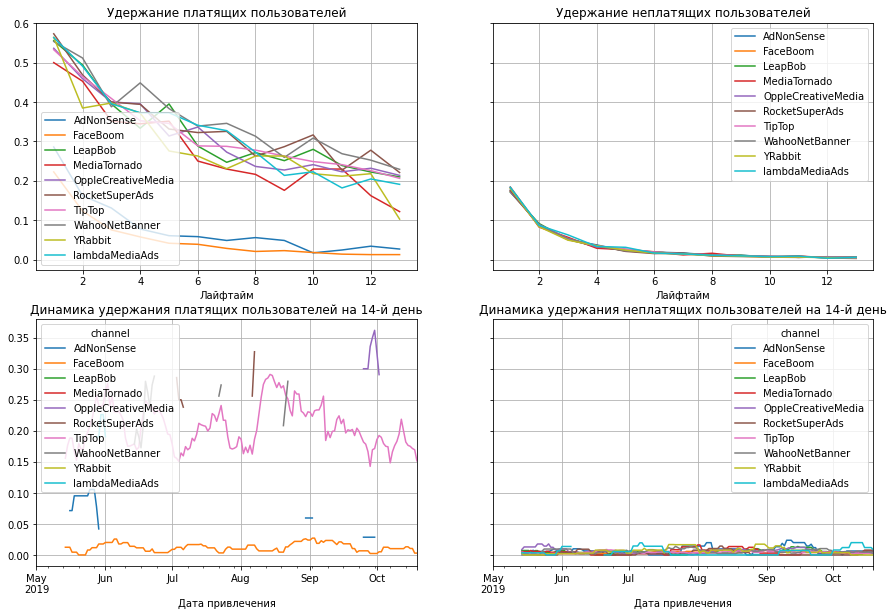

In [52]:
#  вызовем функцию и построим график
    
plt.tight_layout()
plt.show()

plot_retention(retention, retention_history,14) 

# Шаг 6. Выводы


Маркетинговый аналитик развлекательного приложения Procrastinate Pro+ провёл исследование вывгруженных данных. В ходе работы была проведена предподготовка данных, созданы профили пользователей, заданы необходимые для работы функции. При помощи специальных методов расчитаны показатели перевода в платящие пользователи, общая выручка в разрезе , стоимость привлечения пользователя, окупаемость рекламных расходов и другие. Для визуализации применены необходимые графические приёмы.

В результате анализа можно сделать следующие выводы:

* большинство показателей зависимости от устройств значимых расхождений не выявило. Наибольшую выручку обеспечивают владельцы iPhone, но и САС выше у них же. Владельцы Мас принесли наименьшую выручку, а САС - лишь немного уступает уровню владельцев iPhone.Что касается владельцев РС, то у них самый низкий САС и LTV, но самая высокая средняя выручка и окупаемость рекламы.

* в результате исследования показателей в зависимости от стран выяснилось, что расходы на привлечение клиентов в United States выросли более чем в 4 раза, а LTV только в 1,3. Выручка в United States превышает уровень выручки других стран более чем в 5 раз. Процент платящих пользователей и конверсия в United States также выше более чем в 1,5 раза уровня ближайших конкурентов. Окупаемость рекламы в United States гораздо ниже, чем в других странах и продолжает снижаться. Удержание в на самом низком уровне.

* анализируя рекламные каналы установленовлено резкое увеличение САС на канале TipTop- в 3,5 раза от первоначального,  LTV на этом канале также увеличился 3,7 раза, но LTV на канале lambdaMediaAds также вырос в 3,5 раза без резкого увеличения САС. Также на канале lambdaMediaAds выявлен более резкий относительно  других каналов рост конверсии. Маркетинговые расходы  в анализируемом периоде были в несколко раз увеличены на каналах TipTop и FaceBoom. Но САС на канале FaceBoom не вырос, в отличие от канала TipTop. FaceBoom показал самое низкое удержание.

* общая сумма расходов на маркетинг не окупилась к концу анализируемого периода . Неоправданно большие расходы понесены в United States и в канал TipTop.

Рекомендации для отдела маркетинга: 

* обратить внимание на регион распространения рекламы - United States: неоправданно высокие траты на маркетинг в этом регионе не окупаются .Удержание в United States  на самом низком уровне. Так же не окупились  расходы на каналах привлечения TipTop  и FaceBoom. Следует выясмнить причину низкого показателя удержания в стране United States и на канале FaceBoom.

* обратить внимание на каналы рекомендуемые для маркетинговых вложений:  YRabbit-у него самая высокая окупаемость и lambdaMediaAds - хороший показатель роста LTV  ;

* принять к сведению, что владельцы Мас- не самые лучшие покупатели, но имеют самую высокую конверсию, а лучшая окупаемость рекламы среди устройств у владельцев РС. 